# Cluster Dinámico 2013-2022

**LIBRERÍAS**

In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

**DATASETS**

In [2]:
CWD = os.getcwd()
DATA_PATH = r'C:\Users\andre\OneDrive\Documentos\BOOTCAMP\Capstone Project\capstone2030\data_cluster\df_cluster_dinamico.xlsx'
ruta_data = os.path.join(CWD, DATA_PATH)

In [3]:
df = pd.read_excel(ruta_data)

# EDA y PREPROCESSING

In [4]:
df.sort_values('Index_year', inplace=True)

In [5]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [6]:
report_df(df)

df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 195 to 0
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID_Country             196 non-null    object 
 1   Index_year             196 non-null    int64  
 2   Gender Equality Index  196 non-null    float64
 3   WORK                   196 non-null    float64
 4   MONEY                  196 non-null    float64
 5   KNOWLEDGE              196 non-null    float64
 6   TIME                   196 non-null    float64
 7   POWER                  196 non-null    float64
 8   HEALTH                 196 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 15.3+ KB
None

Tenemos un total de 0 nulos


,ID_Country,Index_year,Gender Equality Index,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
195,SE,2013,80.132400,80.429319,85.282798,70.665909,84.452760,77.794433,93.150630
168,EU,2013,63.124903,69.704782,79.103425,59.811560,65.212871,41.867705,86.662770
169,BE,2013,69.255331,72.683965,85.530354,70.648547,70.311895,47.902361,86.474294
170,BG,2013,55.038562,67.896490,60.842341,50.398496,43.898011,45.813493,75.311166
171,CZ,2013,55.569285,64.873858,73.758246,55.438021,53.790792,31.028782,85.734183


In [7]:
country_id = df["ID_Country"].nunique()
year_unique = df["Index_year"].nunique()

print(f'''Tenemos un total de {country_id} países únicos,\n
para un total de {year_unique} años reportados''')

Tenemos un total de 28 países únicos,

para un total de 7 años reportados


In [8]:
columns_list = (df.columns).tolist()

In [9]:
features = df.columns

boolean_columns = [col for col in features if df[col].nunique() == 2]

# Obtener las columnas numéricas
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
numeric_columns = [col for col in numeric_columns if df[col].nunique() > 2]

# Filtrar las columnas object (string y más de dos valores únicos)
object_columns = df.select_dtypes(include=object).columns.tolist()
object_columns = [col for col in object_columns if df[col].nunique() > 2]

# Mostrar las listas resultantes
print("Columnas booleanas:", boolean_columns)
print("Columnas numéricas:", numeric_columns)
print("Columnas object:", object_columns)

Columnas booleanas: []
Columnas numéricas: ['Index_year', 'Gender Equality Index', 'WORK', 'MONEY', 'KNOWLEDGE', 'TIME', 'POWER', 'HEALTH']
Columnas object: ['ID_Country']


In [10]:
#creamos una columna con la diferencia entre el año actual y el anterior
for i in numeric_columns:
  df[f"{i}_dif"] = df.groupby('ID_Country')[i].transform(
      lambda series: series - (series.shift(1))
  )

In [11]:
#creamos una columna para asignar la media de la variación de cada país
for i in numeric_columns:
  df[f"{i}_difavg"] = df.groupby(['ID_Country'])[f"{i}_dif"].transform(
      lambda series: series.mean()
  )

In [12]:
#Dataset para ver crecimiento de último año
df2022 = df[df['Index_year'] == 2022]


In [13]:
GEI = df2022[['ID_Country', 'Gender Equality Index']]

In [14]:
df2022 = df2022[['WORK_dif', 'MONEY_dif', 'KNOWLEDGE_dif', 'TIME_dif','POWER_dif', 'HEALTH_dif', 	'ID_Country']]


In [15]:
#Se eliminan duplicados para quedarnos por un registro por país
df = df.drop_duplicates(subset='ID_Country', keep='last')

In [16]:
report_df(df)

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 11 to 0
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID_Country                    28 non-null     object 
 1   Index_year                    28 non-null     int64  
 2   Gender Equality Index         28 non-null     float64
 3   WORK                          28 non-null     float64
 4   MONEY                         28 non-null     float64
 5   KNOWLEDGE                     28 non-null     float64
 6   TIME                          28 non-null     float64
 7   POWER                         28 non-null     float64
 8   HEALTH                        28 non-null     float64
 9   Index_year_dif                28 non-null     float64
 10  Gender Equality Index_dif     28 non-null     float64
 11  WORK_dif                      28 non-null     float64
 12  MONEY_dif                     28 non-null     float64
 13  KNOWLEDGE_di

Se crean distintos dataserts que se usarán más adelante

In [17]:
df.set_index('ID_Country', inplace=True)

In [18]:
dfEU = df[df.index =='EU']

In [19]:
dfEU = dfEU[['WORK_difavg', 'MONEY_difavg', 'KNOWLEDGE_difavg', 'TIME_difavg', 'POWER_difavg', 'HEALTH_difavg', 'Gender Equality Index' ]]

In [20]:
df = df[['WORK_difavg', 'MONEY_difavg', 'KNOWLEDGE_difavg', 'TIME_difavg', 'POWER_difavg', 'HEALTH_difavg', ]]

In [21]:
dfEU1 = dfEU.copy()

In [22]:
dfEU.rename(columns={'WORK_difavg': 'WORK_difavg_mean', 'MONEY_difavg':'MONEY_difavg_mean', 'KNOWLEDGE_difavg':'KNOWLEDGE_difavg_mean', 'TIME_difavg':'TIME_difavg_mean', 'POWER_difavg':'POWER_difavg_mean', 'HEALTH_difavg':'HEALTH_difavg_mean'}, inplace=True)

In [23]:
df.drop('EU', inplace=True)

# MODELO K-MEANS

In [24]:
#Inercia para calcular la curva del codo
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


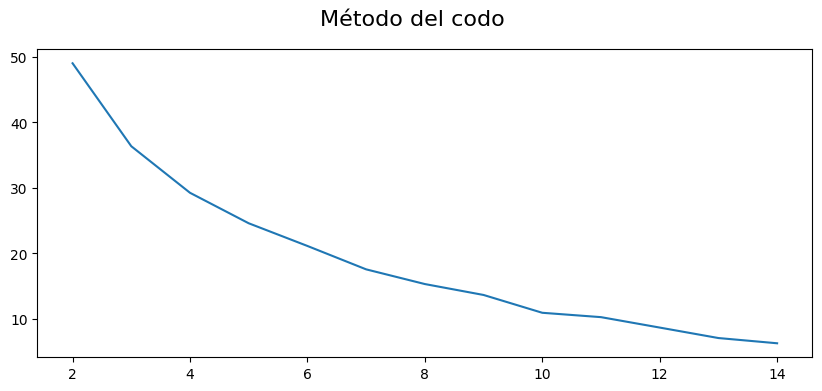

In [25]:
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Método del codo", fontsize = 16);

In [26]:
#pipe con los pasos del modelo
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 5, random_state = 175))
])

In [27]:
df.shape

(27, 6)

In [28]:
pipe.fit(df)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=5, random_state=175))])

Una parte muy interesante de los pipelines es que la podemos filtrar (igual que una lista de python) y usar sólo parte de los pasos que tenemos implementados.

In [29]:
pipe[:1]

Pipeline(steps=[('Imputer', KNNImputer())])

In [30]:
X_processed = pipe[:1].transform(df)

In [31]:
X_processed_scaled = pipe[:2].transform(df)

In [32]:
X_processed_scaled.shape

(27, 6)

In [33]:
X_processed_scaled.sample(3)

,WORK_difavg,MONEY_difavg,KNOWLEDGE_difavg,TIME_difavg,POWER_difavg,HEALTH_difavg
ID_Country,,,,,,
SE,0.067988,-0.234150,0.104653,0.198793,-0.226215,0.017423
LU,0.325127,-0.220945,-0.017813,-0.254905,0.557187,-0.193568
HR,0.054482,0.145258,0.067314,-0.099443,0.191229,0.237928


In [34]:
pipe[-1].cluster_centers_.shape

(5, 6)

In [35]:
pipe[0]

KNNImputer()

In [36]:
pipe[-1].cluster_centers_[0]

array([ 0.00984006, -0.09768197, -0.42212607, -0.3389264 ,  0.07216963,
       -0.07020665])

In [37]:
X_results = pipe[-1].transform(df)

In [38]:
X_results.sample(3)

,kmeans0,kmeans1,kmeans2,kmeans3,kmeans4
ID_Country,,,,,
MT,4.350936,4.335931,4.011590,3.565198,4.447735
SI,2.439328,2.432036,2.013027,2.268336,2.449743
GR,2.336689,1.993549,1.825177,1.976881,2.360312


In [39]:
labels = pipe.predict(df)

In [40]:
len(labels)

27

In [41]:
# le asignamos al DataFrame procesado el clúster.
# si lo hacemos al df escalado será más díficil de interpretar los resultados porque los números están escalados
X_processed["cluster"] = labels

In [42]:
X_processed.head()

,WORK_difavg,MONEY_difavg,KNOWLEDGE_difavg,TIME_difavg,POWER_difavg,HEALTH_difavg,cluster
ID_Country,,,,,,,
HR,0.403139,0.916046,0.588682,0.207356,3.558369,0.595591,2
FR,0.282784,0.198488,0.592871,0.125123,4.871586,0.315301,2
ES,0.304585,0.265044,0.796698,0.537505,4.666176,0.517690,2
GR,0.321388,-0.404746,0.398751,1.523617,1.083898,0.249583,1
IE,0.497702,0.329716,0.473627,0.551900,4.080354,0.706046,2


In [43]:
X_processed.shape

(27, 7)

In [44]:
df.columns

Index(['WORK_difavg', 'MONEY_difavg', 'KNOWLEDGE_difavg', 'TIME_difavg',
       'POWER_difavg', 'HEALTH_difavg'],
      dtype='object')

In [45]:
X_processed.head()

,WORK_difavg,MONEY_difavg,KNOWLEDGE_difavg,TIME_difavg,POWER_difavg,HEALTH_difavg,cluster
ID_Country,,,,,,,
HR,0.403139,0.916046,0.588682,0.207356,3.558369,0.595591,2
FR,0.282784,0.198488,0.592871,0.125123,4.871586,0.315301,2
ES,0.304585,0.265044,0.796698,0.537505,4.666176,0.517690,2
GR,0.321388,-0.404746,0.398751,1.523617,1.083898,0.249583,1
IE,0.497702,0.329716,0.473627,0.551900,4.080354,0.706046,2


# INTERPRETACIÓN

In [46]:
ficha_df = pd.DataFrame()

In [47]:
ficha_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [48]:
frames = []  # Crear una lista vacía para almacenar los DataFrames intermedios
for i, col in enumerate(['WORK_difavg', 'MONEY_difavg', 'KNOWLEDGE_difavg', 'TIME_difavg','POWER_difavg', 'HEALTH_difavg']):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    frames.append(resumen_data)  # Añadir el DataFrame intermedio a la lista

ficha_df = pd.concat(frames)  # Concatenar todos los DataFrames al final

In [49]:
# generamos nuestro multiindex
out_index = [
    "WORK",
    "MONEY",
    "KNOWLEDGE",
    "TIME",
    "POWER",
    "HEALTH"
]

inner_index = ['WORK_evolution_mean', 'MONEY_evolution_mean', 'KNOWLEDGE_evolution_mean', 'TIME_evolution_mean','POWER_evolution_mean', 'HEALTH_evolution_mean']

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [50]:
ficha_df

cluster                       0         1         2         3         4
WORK_difavg      mean  0.322385  0.265692  0.406220  1.985837  0.157903
                 std   0.247681  0.156480  0.212996       NaN  0.136437
                 min  -0.045491 -0.090136  0.226187  1.985837 -0.107299
                 25%   0.285745  0.244518  0.299135  1.985837  0.163208
                 50%   0.431483  0.301171  0.321324  1.985837  0.190184
                 75%   0.468122  0.342026  0.426779  1.985837  0.237202
                 max   0.472065  0.427570  0.892715  1.985837  0.267260
MONEY_difavg     mean  0.394906  0.412951  0.447377  0.735321  1.400805
                 std   0.430794  0.404207  0.302598       NaN  0.441267
                 min  -0.001407 -0.404746  0.130491  0.735321  0.560956
                 25%   0.036356  0.317222  0.242652  0.735321  1.365201
                 50%   0.383755  0.491046  0.297380  0.735321  1.513379
                 75%   0.742305  0.644508  0.720297  0.735321  1.696306
                 max   0.813522  0.866053  0.916046  0.735321  1.744026
KNOWLEDGE_difavg mean -0.247875  0.492030  0.708185 -0.044718  0.421593
                 std   0.287737  0.293995  0.209068       NaN  0.480099
                 min  -0.640806  0.167183  0.443181 -0.044718 -0.243254
                 25%  -0.367169  0.338794  0.559918 -0.044718  0.081946
                 50%  -0.180562  0.414012  0.694784 -0.044718  0.509122
                 75%  -0.061268  0.594268  0.881096 -0.044718  0.764881
                 max   0.010428  1.104235  0.966428 -0.044718  0.964879
TIME_difavg      mean -0.380508  0.909537  0.325976  1.649469 -0.045968
                 std   0.599481  0.477463  0.399801       NaN  0.394313
                 min  -0.837967  0.043605 -0.207360  1.649469 -0.463582
                 25%  -0.808437  0.711861  0.050277  1.649469 -0.275668
                 50%  -0.567762  0.920418  0.372431  1.649469 -0.165402
                 75%  -0.139833  1.165317  0.588327  1.649469  0.112055
                 max   0.451460  1.523617  0.869936  1.649469  0.626461
POWER_difavg     mean  2.867827  1.307811  4.360829  3.248186  1.428037
                 std   1.188429  1.251269  0.935721       NaN  0.959211
                 min   1.868553 -0.223750  2.862672  3.248186  0.300734
                 25%   1.968541  0.295429  3.805757  3.248186  0.679755
                 50%   2.595151  1.110547  4.373265  3.248186  1.444249
                 75%   3.494437  2.137515  4.973270  3.248186  2.066163
                 max   4.412454  3.440745  5.680929  3.248186  2.680600
HEALTH_difavg    mean  0.241887  0.123534  0.397765 -0.456152  0.339187
                 std   0.331866  0.168796  0.232078       NaN  0.144902
                 min  -0.129309 -0.149581  0.041297 -0.456152  0.078685
                 25%   0.051839  0.033264  0.261546 -0.456152  0.334364
                 50%   0.222917  0.081164  0.452959 -0.456152  0.356768
                 75%   0.412965  0.267807  0.537166 -0.456152  0.384947
                 max   0.651022  0.342476  0.706046 -0.456152  0.521666

In [51]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [52]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [53]:
index_ficha

MultiIndex([(     'WORK',      'WORK_evolution_mean',      'Media'),
            (     'WORK',      'WORK_evolution_mean', 'Desviación'),
            (     'WORK',      'WORK_evolution_mean',     'Mínimo'),
            (     'WORK',      'WORK_evolution_mean',   'Perc. 25'),
            (     'WORK',      'WORK_evolution_mean',   'Perc. 50'),
            (     'WORK',      'WORK_evolution_mean',   'Perc. 75'),
            (     'WORK',      'WORK_evolution_mean',     'Máximo'),
            (    'MONEY',     'MONEY_evolution_mean',      'Media'),
            (    'MONEY',     'MONEY_evolution_mean', 'Desviación'),
            (    'MONEY',     'MONEY_evolution_mean',     'Mínimo'),
            (    'MONEY',     'MONEY_evolution_mean',   'Perc. 25'),
            (    'MONEY',     'MONEY_evolution_mean',   'Perc. 50'),
            (    'MONEY',     'MONEY_evolution_mean',   'Perc. 75'),
            (    'MONEY',     'MONEY_evolution_mean',     'Máximo'),
            ('KNOWLEDGE', 'KNOWLED

In [54]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [55]:
tamaño_clusters

,,cluster,0,1,2,3,4
Grupo Indicadores,Indicador,Estadístico,,,,,
General,Clúster,Tamaño,4,8,8,1,6


Se añade una columna conel GEI y una fila con la media de la UE al dataset con los clusters

In [56]:
XP1 = X_processed.copy()

In [57]:
XP1 = pd.merge(XP1, GEI, on='ID_Country')


In [58]:
XP1.set_index('ID_Country', inplace=True)

In [59]:
for i in XP1.columns:
  XP1[f"{i}_mean"] = XP1.groupby(['cluster'])[i].transform(
      lambda series: series.mean()
  )

In [60]:
XP1.drop_duplicates('cluster', inplace=True)

In [61]:
XP1 = XP1[['WORK_difavg_mean', 'MONEY_difavg_mean', 'KNOWLEDGE_difavg_mean', 'TIME_difavg_mean', 'POWER_difavg_mean', 'HEALTH_difavg_mean', 'Gender Equality Index_mean', 'cluster']]

In [62]:
lista_dataframes = [dfEU, XP1]

In [63]:
df_clusters_means = pd.concat(lista_dataframes, ignore_index=False)

In [64]:
df_clusters_means['Gender Equality Index'].fillna(df_clusters_means['Gender Equality Index_mean'], inplace=True)
df_clusters_means.drop(columns=['Gender Equality Index_mean'], inplace=True)

In [65]:
df_clusters_means.fillna('EU', inplace=True)

In [66]:
df_clusters_means.set_index('cluster', inplace=True)

In [67]:
df_clusters_means = df_clusters_means.rename({
    0 : "Aumento en MONEY",
    1 : "Mejora considerable en POWER",
    2 : "Outlier",
    3 : "Solo mejora en POWER",
    4 : "Estancados en todos los dominios"
})

In [68]:
df_clusters_means.style.background_gradient(cmap = 'Blues', axis = 0)

,WORK_difavg_mean,MONEY_difavg_mean,KNOWLEDGE_difavg_mean,TIME_difavg_mean,POWER_difavg_mean,HEALTH_difavg_mean,Gender Equality Index
cluster,,,,,,,
EU,0.327542,0.578185,0.440814,-0.048175,2.561628,0.339937,68.569374
Outlier,0.406220,0.447377,0.708185,0.325976,4.360829,0.397765,69.100540
Mejora considerable en POWER,0.265692,0.412951,0.492030,0.909537,1.307811,0.123534,61.546706
Aumento en MONEY,0.322385,0.394906,-0.247875,-0.380508,2.867827,0.241887,74.486946
Estancados en todos los dominios,0.157903,1.400805,0.421593,-0.045968,1.428037,0.339187,61.643672
Solo mejora en POWER,1.985837,0.735321,-0.044718,1.649469,3.248186,-0.456152,65.602472


In [69]:
ficha_df

cluster                                                        0         1  \
Grupo Indicadores Indicador                Estadístico                       
WORK              WORK_evolution_mean      Media        0.322385  0.265692   
                                           Desviación   0.247681  0.156480   
                                           Mínimo      -0.045491 -0.090136   
                                           Perc. 25     0.285745  0.244518   
                                           Perc. 50     0.431483  0.301171   
                                           Perc. 75     0.468122  0.342026   
                                           Máximo       0.472065  0.427570   
MONEY             MONEY_evolution_mean     Media        0.394906  0.412951   
                                           Desviación   0.430794  0.404207   
                                           Mínimo      -0.001407 -0.404746   
                                           Perc. 25     0.036356  0.317222   
                                           Perc. 50     0.383755  0.491046   
                                           Perc. 75     0.742305  0.644508   
                                           Máximo       0.813522  0.866053   
KNOWLEDGE         KNOWLEDGE_evolution_mean Media       -0.247875  0.492030   
                                           Desviación   0.287737  0.293995   
                                           Mínimo      -0.640806  0.167183   
                                           Perc. 25    -0.367169  0.338794   
                                           Perc. 50    -0.180562  0.414012   
                                           Perc. 75    -0.061268  0.594268   
                                           Máximo       0.010428  1.104235   
TIME              TIME_evolution_mean      Media       -0.380508  0.909537   
                                           Desviación   0.599481  0.477463   
                                           Mínimo      -0.837967  0.043605   
                                           Perc. 25    -0.808437  0.711861   
                                           Perc. 50    -0.567762  0.920418   
                                           Perc. 75    -0.139833  1.165317   
                                           Máximo       0.451460  1.523617   
POWER             POWER_evolution_mean     Media        2.867827  1.307811   
                                           Desviación   1.188429  1.251269   
                                           Mínimo       1.868553 -0.223750   
                                           Perc. 25     1.968541  0.295429   
                                           Perc. 50     2.595151  1.110547   
                                           Perc. 75     3.494437  2.137515   
                                           Máximo       4.412454  3.440745   
HEALTH            HEALTH_evolution_mean    Media        0.241887  0.123534   
                                           Desviación   0.331866  0.168796   
                                           Mínimo      -0.129309 -0.149581   
                                           Perc. 25     0.051839  0.033264   
                                           Perc. 50     0.222917  0.081164   
                                           Perc. 75     0.412965  0.267807   
                                           Máximo       0.651022  0.342476   

cluster                                                        2         3  \
Grupo Indicadores Indicador                Estadístico                       
WORK              WORK_evolution_mean      Media        0.406220  1.985837   
                                           Desviación   0.212996       NaN   
                                           Mínimo       0.226187  1.985837   
                                           Perc. 25     0.299135  1.985837   
                                           Perc. 50     0.321324  1.985837   
                     

In [70]:
print(type(tamaño_clusters))
print(type(ficha_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [75]:
ficha_df = pd.concat([ficha_df, tamaño_clusters]).reset_index(drop=False)


In [76]:
ficha_df = ficha_df.rename(columns = {
    0 : "Aumento en MONEY",
    1 : "Mejora considerable en POWER",
    2 : "Outlier",
    3 : "Solo mejora en POWER",
    4 : "Estancados en todos los dominios"
    })

In [77]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

cluster,index,Grupo Indicadores,Indicador,Estadístico,Aumento en MONEY,Mejora considerable en POWER,Outlier,Solo mejora en POWER,Estancados en todos los dominios
0,0,WORK,WORK_evolution_mean,Media,0.322385,0.265692,0.406220,1.985837,0.157903
1,1,WORK,WORK_evolution_mean,Desviación,0.247681,0.156480,0.212996,nan,0.136437
2,2,WORK,WORK_evolution_mean,Mínimo,-0.045491,-0.090136,0.226187,1.985837,-0.107299
3,3,WORK,WORK_evolution_mean,Perc. 25,0.285745,0.244518,0.299135,1.985837,0.163208
4,4,WORK,WORK_evolution_mean,Perc. 50,0.431483,0.301171,0.321324,1.985837,0.190184
5,5,WORK,WORK_evolution_mean,Perc. 75,0.468122,0.342026,0.426779,1.985837,0.237202
6,6,WORK,WORK_evolution_mean,Máximo,0.472065,0.427570,0.892715,1.985837,0.267260
7,7,MONEY,MONEY_evolution_mean,Media,0.394906,0.412951,0.447377,0.735321,1.400805
8,8,MONEY,MONEY_evolution_mean,Desviación,0.430794,0.404207,0.302598,nan,0.441267
9,9,MONEY,MONEY_evolution_mean,Mínimo,-0.001407,-0.404746,0.130491,0.735321,0.560956


# DATOS SOCIOECONÓMICOS

Se carga dataset con datos socioeconómicos y se integra con el dataset obtenido

In [80]:
DATA_PATH = r'C:\Users\andre\OneDrive\Documentos\BOOTCAMP\Capstone Project\capstone2030\data_cluster\df_EU_info_extra.xlsx'
ruta_data_info = os.path.join(CWD, DATA_PATH)
df_info = pd.read_excel(ruta_data_info)
df_info.head()

,ID_Country,Población,PIB anual,PIB Per Capita,IDH,Deuda total (M.€),Deuda (%PIB),Déficit (%PIB)
0,Alemania,84358845.0,4121160.0,48750.0,0.942,2561675.0,0.661,-0.025
1,Austria,9104772.0,447218.0,49400.0,0.916,350698.0,0.784,-0.035
2,Bélgica,11754004.0,554044.0,47440.0,0.937,578063.0,1.043,-0.039
3,Bulgaria,6447710.0,85801.0,13270.0,0.795,19353.0,0.226,-0.029
4,Chequia,10827529.0,276266.0,25850.0,0.889,124300.0,0.442,-0.032


In [81]:
X_processed.fillna('EU', inplace=True)

In [82]:
X_processed = pd.merge(X_processed, GEI, on='ID_Country')

In [83]:
X_processed = pd.concat([X_processed, dfEU1])

In [84]:
X_processed.drop_duplicates('ID_Country', inplace=True)


In [85]:
X_processed.fillna('EU', inplace=True)

In [86]:
df_index_EU_updated = X_processed # aqui mi excel de paises EU con el cluster
df_EU_info_extra_updated = df_info # el que te he pasado arriba

country_mapping = {
    "Alemania": "DE",
    "Austria": "AT",
    "Bélgica": "BE",
    "Bulgaria": "BG",
    "Chequia": "CZ",
    "Dinamarca": "DK",
    "España": "ES",
    "Estonia": "EE",
    "Finlandia": "FI",
    "Francia": "FR",
    "Grecia": "GR",
    "Hungría": "HU",
    "Irlanda": "IE",
    "Italia": "IT",
    "Letonia": "LV",
    "Lituania": "LT",
    "Luxemburgo": "LU",
    "Malta": "MT",
    "Países Bajos": "NL",
    "Polonia": "PL",
    "Portugal": "PT",
    "Rumanía": "RO",
    "Suecia": "SE",
    "EU": "EU",
    'Croacia': 'HR',
    'Chipre': 'CY',
    'Eslovaquia': 'SK',
    'Eslovenia': 'SI'

    # Añadir más mapeos según sea necesario
}

# Aplicar el mapeo al DataFrame df_EU_info_extra
df_EU_info_extra_updated['ID_Country'] = df_EU_info_extra_updated['ID_Country'].map(country_mapping)

# Unir los DataFrames basados en 'ID_Country'
df_combined = pd.merge(df_index_EU_updated, df_EU_info_extra_updated, on='ID_Country', how='left')


In [87]:
df_combined.set_index('ID_Country', inplace=True)

In [88]:
clusters = df_combined.copy()

In [89]:
clusters.set_index('cluster', inplace=True)

In [90]:
#se crea columna con la media de cada cluster
for i in clusters.columns:
    clusters[f"{i}_mean"] = clusters.groupby(clusters.index)[i].transform(
      lambda series: series.mean()
  )

In [91]:
clusters = clusters[['WORK_difavg_mean', 'MONEY_difavg_mean', 'KNOWLEDGE_difavg_mean', 'TIME_difavg_mean', 'POWER_difavg_mean', 'HEALTH_difavg_mean', 'Gender Equality Index', 'Población_mean', 'IDH_mean', 'Deuda total (M.€)_mean', 'Deuda (%PIB)_mean', 'Déficit (%PIB)_mean'
]]

In [92]:
clusters

,WORK_difavg_mean,MONEY_difavg_mean,KNOWLEDGE_difavg_mean,TIME_difavg_mean,POWER_difavg_mean,HEALTH_difavg_mean,Gender Equality Index,Población_mean,IDH_mean,Deuda total (M.€)_mean,Deuda (%PIB)_mean,Déficit (%PIB)_mean
cluster,,,,,,,,,,,,
2.0,0.406220,0.447377,0.708185,0.325976,4.360829,0.397765,60.689344,2.506348e+07,0.893375,983750.375000,0.754250,-0.028038
2.0,0.406220,0.447377,0.708185,0.325976,4.360829,0.397765,75.140792,2.506348e+07,0.893375,983750.375000,0.754250,-0.028038
2.0,0.406220,0.447377,0.708185,0.325976,4.360829,0.397765,74.554945,2.506348e+07,0.893375,983750.375000,0.754250,-0.028038
1.0,0.265692,0.412951,0.492030,0.909537,1.307811,0.123534,53.415973,7.534234e+06,0.887125,147539.625000,0.814625,-0.016750
2.0,0.406220,0.447377,0.708185,0.325976,4.360829,0.397765,74.330251,2.506348e+07,0.893375,983750.375000,0.754250,-0.028038
0.0,0.322385,0.394906,-0.247875,-0.380508,2.867827,0.241887,74.196806,2.996420e+07,0.942000,933468.000000,0.625750,-0.008000
0.0,0.322385,0.394906,-0.247875,-0.380508,2.867827,0.241887,68.664431,2.996420e+07,0.942000,933468.000000,0.625750,-0.008000
0.0,0.322385,0.394906,-0.247875,-0.380508,2.867827,0.241887,77.832795,2.996420e+07,0.942000,933468.000000,0.625750,-0.008000
1.0,0.265692,0.412951,0.492030,0.909537,1.307811,0.123534,57.239282,7.534234e+06,0.887125,147539.625000,0.814625,-0.016750


In [93]:
clusters.reset_index(inplace=True)


In [94]:
clusters.drop_duplicates('cluster', inplace=True)

In [95]:
clusters.set_index('cluster', inplace=True)

In [96]:
clusters = clusters.rename({
    0 : "Aumento en MONEY",
    1 : "Mejora considerable en POWER",
    2 : "Outlier",
    3 : "Solo mejora en POWER",
    4 : "Estancados en todos los dominios"
})

In [97]:
clusters.style.background_gradient(cmap = 'Blues', axis = 0)

,WORK_difavg_mean,MONEY_difavg_mean,KNOWLEDGE_difavg_mean,TIME_difavg_mean,POWER_difavg_mean,HEALTH_difavg_mean,Gender Equality Index,Población_mean,IDH_mean,Deuda total (M.€)_mean,Deuda (%PIB)_mean,Déficit (%PIB)_mean
cluster,,,,,,,,,,,,
Outlier,0.406220,0.447377,0.708185,0.325976,4.360829,0.397765,60.689344,25063482.750000,0.893375,983750.375000,0.754250,-0.028038
Mejora considerable en POWER,0.265692,0.412951,0.492030,0.909537,1.307811,0.123534,53.415973,7534234.500000,0.887125,147539.625000,0.814625,-0.016750
Aumento en MONEY,0.322385,0.394906,-0.247875,-0.380508,2.867827,0.241887,74.196806,29964198.500000,0.942000,933468.000000,0.625750,-0.008000
Estancados en todos los dominios,0.157903,1.400805,0.421593,-0.045968,1.428037,0.339187,61.025263,11245906.500000,0.877500,117113.166667,0.445667,-0.028000
Solo mejora en POWER,1.985837,0.735321,-0.044718,1.649469,3.248186,-0.456152,65.602472,542051.000000,0.918000,9001.000000,0.523000,-0.057000
EU,0.327542,0.578185,0.440814,-0.048175,2.561628,0.339937,68.569374,16616889.703704,0.896111,499847.111111,0.675963,-0.022789


In [98]:
df_combined['cluster'].replace({
    0 : "Aumento en MONEY",
    1 : "Mejora considerable en POWER",
    2 : "Outlier",
    3 : "Solo mejora en POWER",
    4 : "Estancados en todos los dominios"
}, inplace=True)


# GRAFICACIÓN

In [99]:
# Calcular medias de todas las variables por cluster
mean_metrics_by_cluster = df_combined.groupby('cluster')[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)', 'Gender Equality Index']].mean()
# Extraer las medias para el cluster 'EU' si existe
if 'EU' in mean_metrics_by_cluster.index:
    eu_means = mean_metrics_by_cluster.loc['EU']
else:
    # Si no existe un cluster 'EU' específicamente, calcularemos la media general como ejemplo
    eu_means = df_combined[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)', 'Gender Equality Index']].mean()
eu_means

Población                1.661689e+07
PIB anual                6.051751e+05
PIB Per Capita           3.783852e+04
IDH                      8.961111e-01
Deuda total (M.€)        4.998471e+05
Deuda (%PIB)             6.759630e-01
Déficit (%PIB)          -2.278889e-02
Gender Equality Index    6.856937e+01
Name: EU, dtype: float64

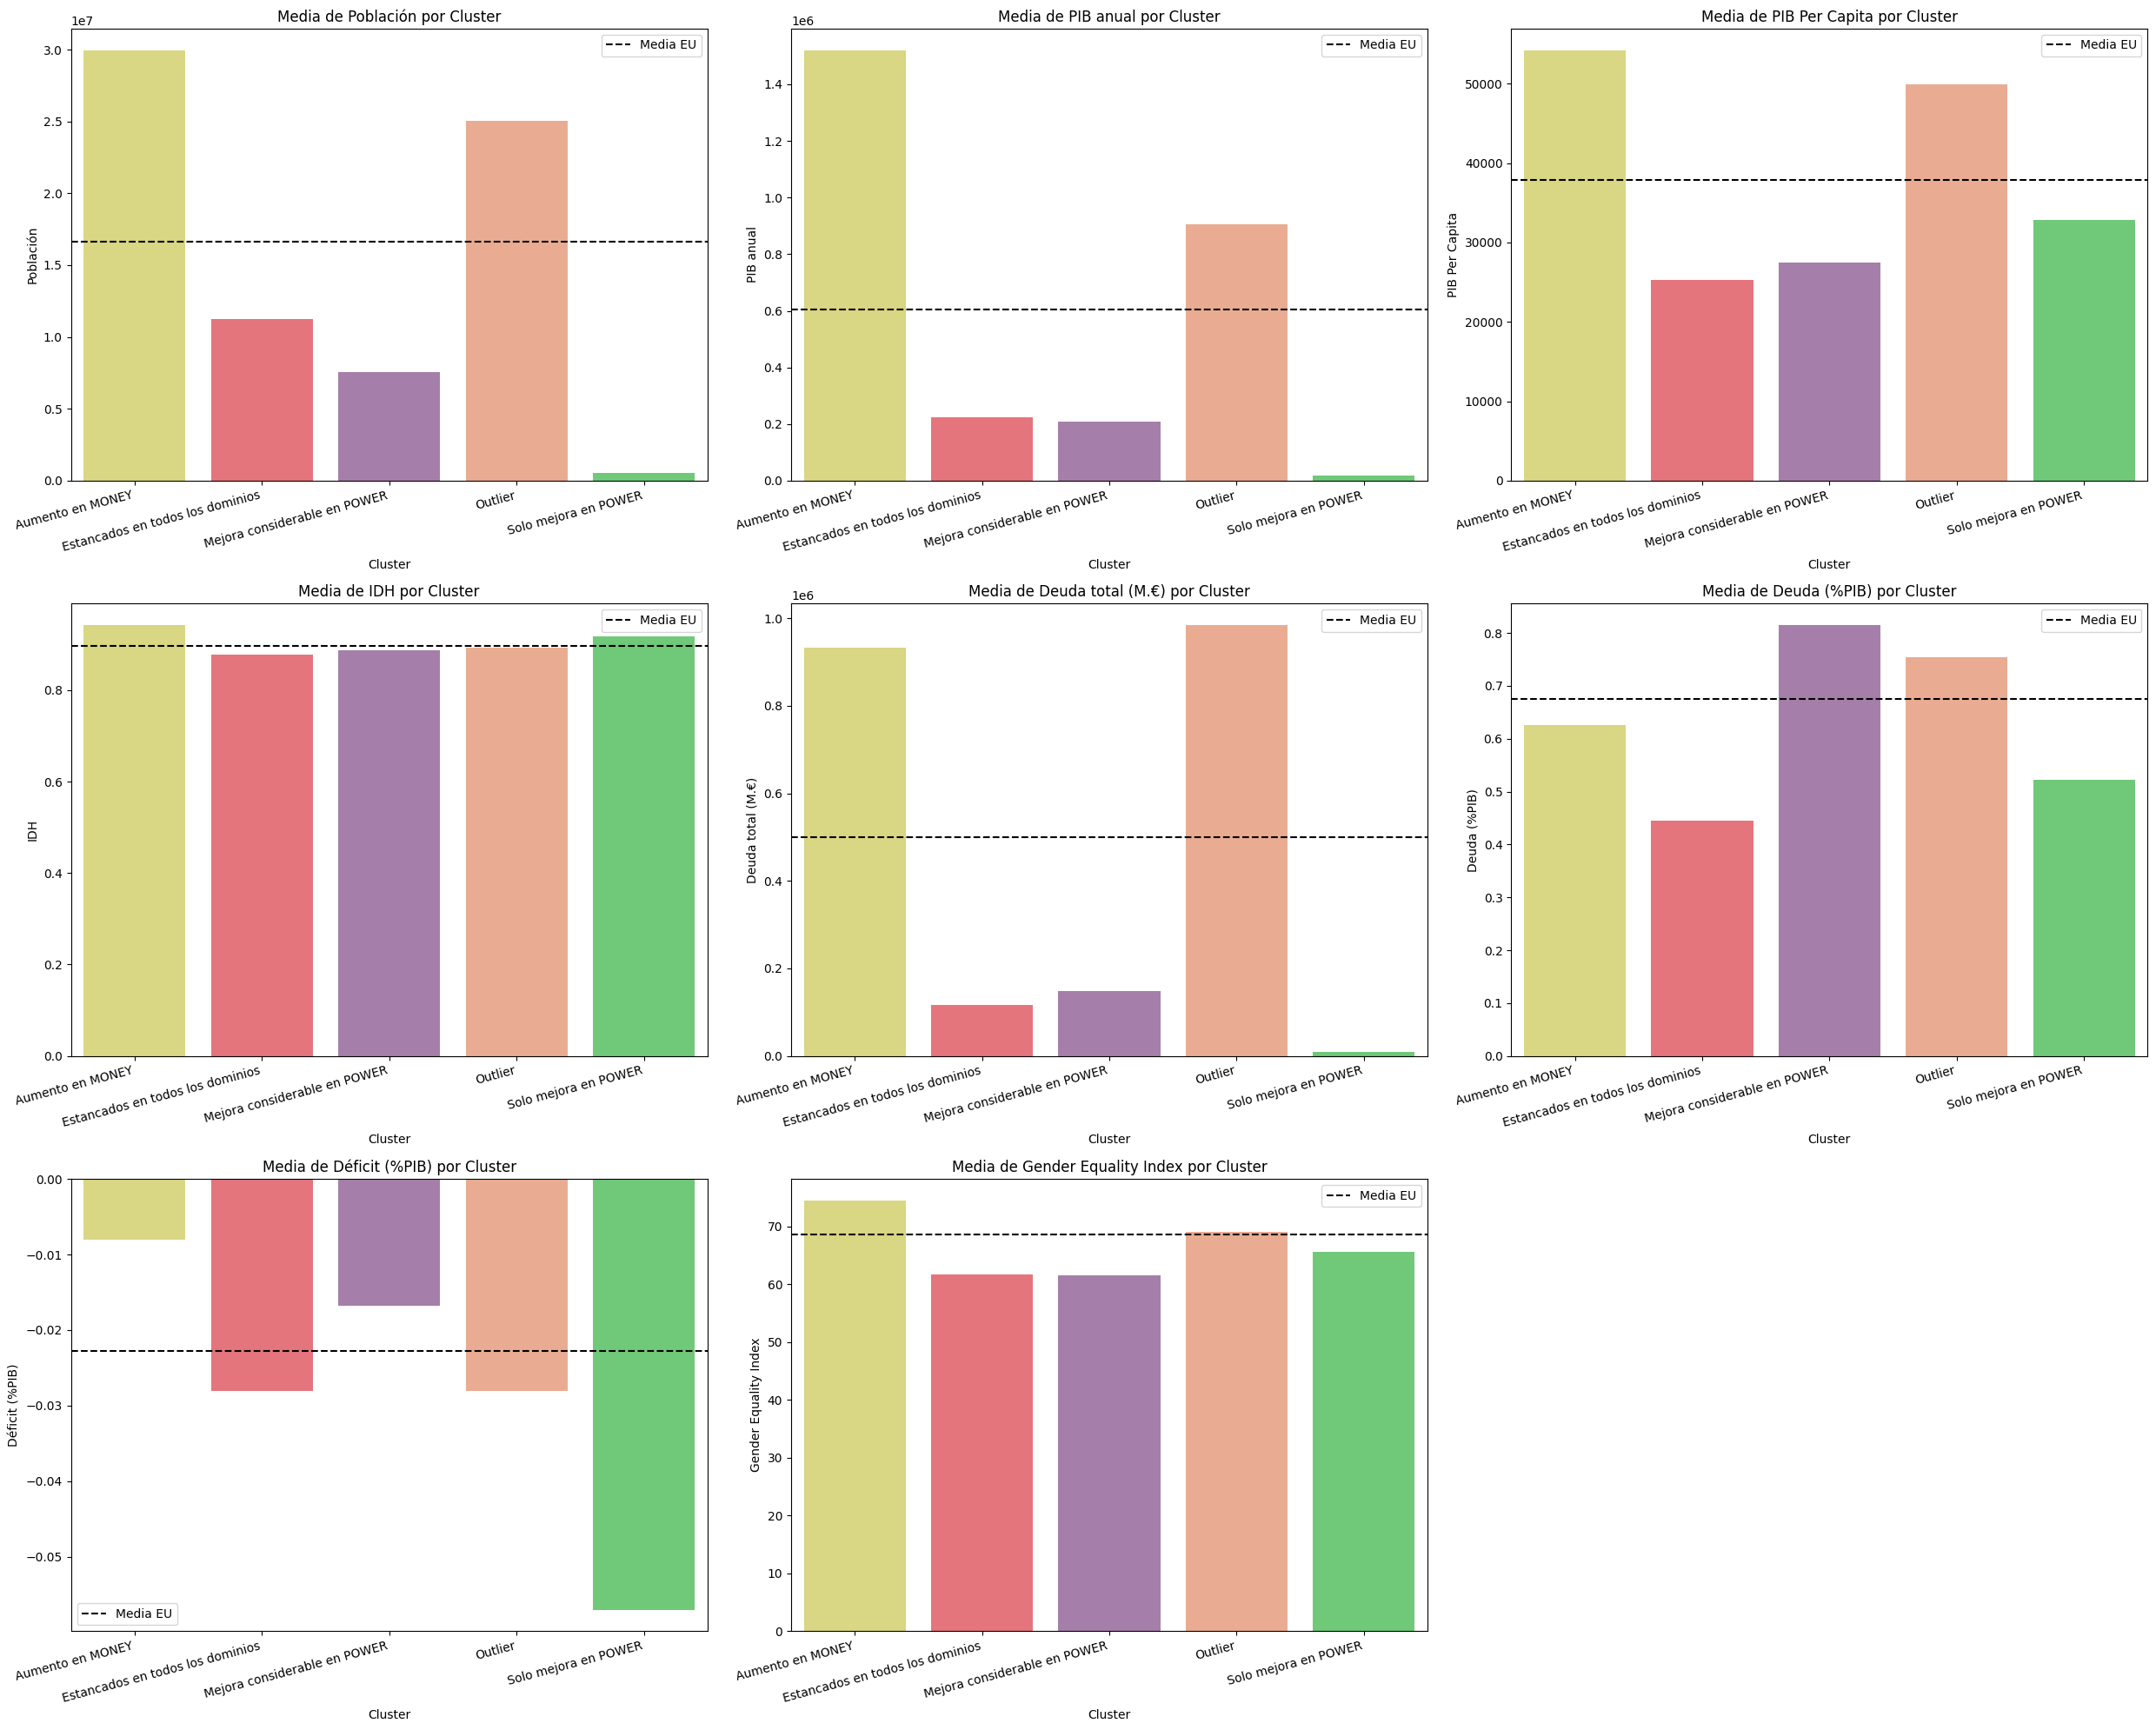

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
# Filtrar el DataFrame para excluir el cluster 'EU'
df_filtered = df_combined[df_combined['cluster'] != 'EU']
# Calcular medias de todas las variables por cluster, excluyendo 'EU'
mean_metrics_by_cluster_filtered = df_filtered.groupby('cluster')[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)', 'Gender Equality Index']].mean()
rows = 3  # Número de filas de gráficas
cols = 3  # Número de columnas de gráficas
fig, ax = plt.subplots(rows, cols, figsize=(25, 20))  # Ajusta el tamaño según necesites
# Definir una paleta de colores específica para cada cluster, sin incluir 'EU'
cluster_colors = {
    'Estancados en todos los dominios': "#F7626C",
    'Aumento en MONEY': "#E7E376",
    'Outlier': "#F8A683",
    'Solo mejora en POWER': "#61D76D",
    'Mejora considerable en POWER': "#AB78B0",
}

for i, column in enumerate(mean_metrics_by_cluster_filtered.columns):
    row = i // cols
    col = i % cols
    sns.barplot(x=mean_metrics_by_cluster_filtered.index, y=mean_metrics_by_cluster_filtered[column], ax=ax[row, col], palette=cluster_colors)
    # Añadir una línea transversal para la media de 'EU'
    ax[row, col].axhline(y=eu_means[column], color='k', linestyle='--', label='Media EU')
    ax[row, col].set_title(f'Media de {column} por Cluster')
    ax[row, col].set_xlabel('Cluster')
    ax[row, col].set_ylabel(column)
    ax[row, col].legend()
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=15, ha="right")
# Ocultar subplots vacíos si los hay
for j in range(i+1, rows*cols):
    fig.delaxes(ax.flatten()[j])
plt.tight_layout()
plt.show()

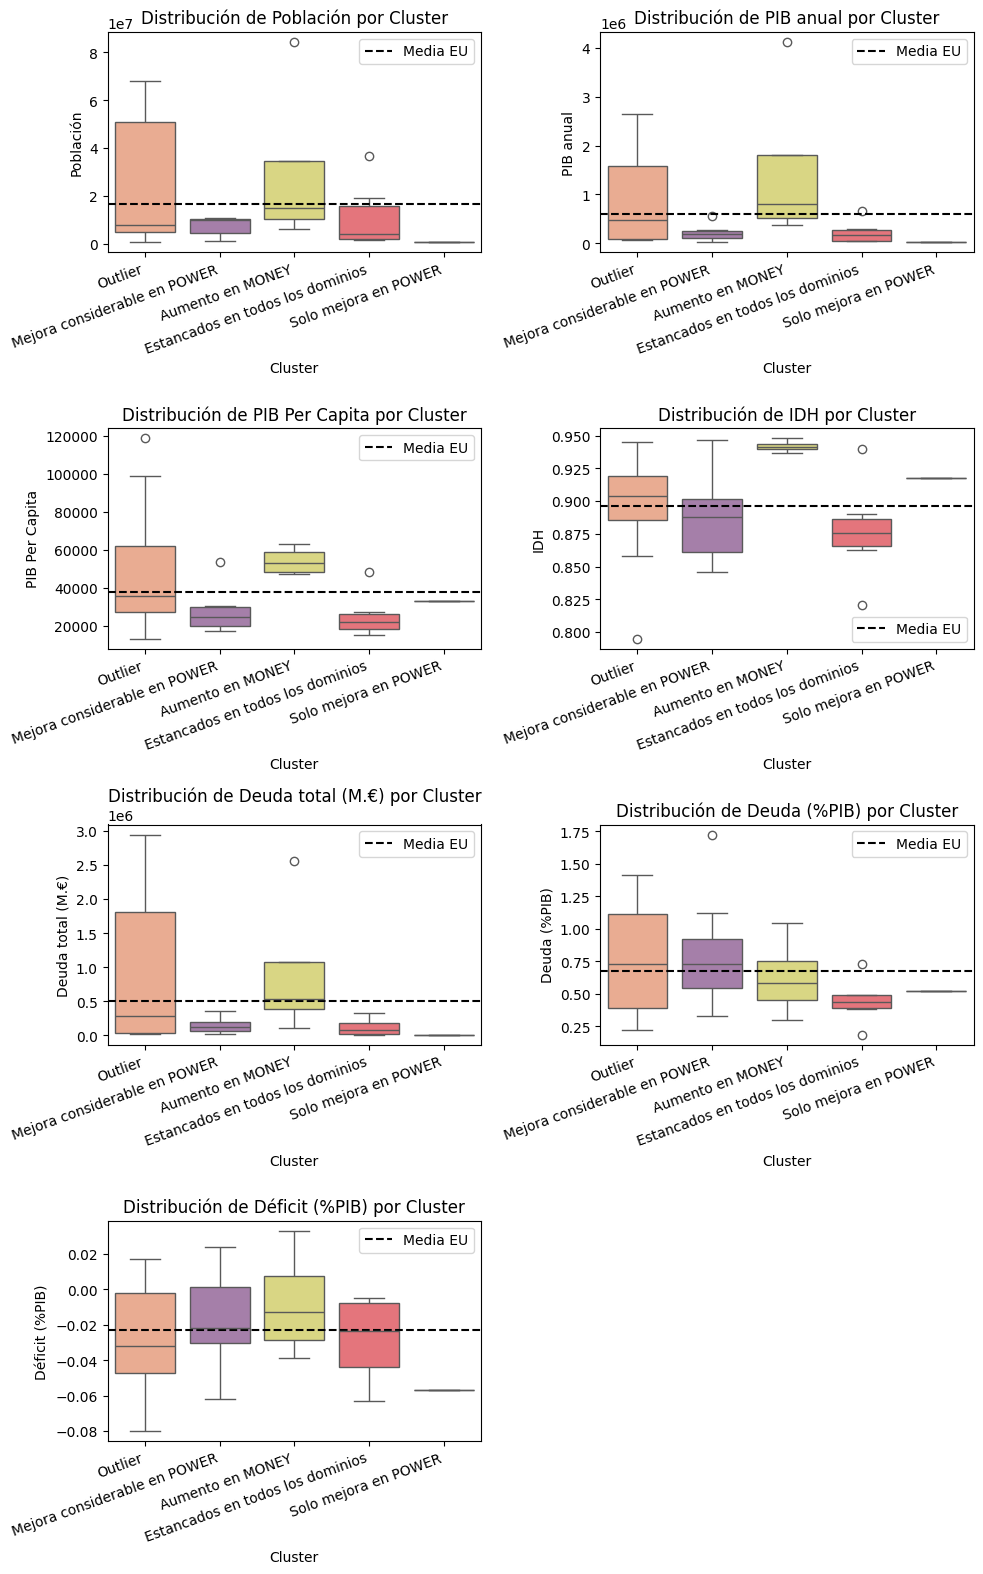

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de todas las variables a graficar
variables = ['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)']

# Calcular el número de filas necesarias basado en el número de variables (asumiendo 2 columnas)
num_vars = len(variables)
rows = (num_vars // 2) + (num_vars % 2)
fig, ax = plt.subplots(rows, 2, figsize=(10, 4 * rows))  # Ajusta el tamaño según el número de filas

# Filtrar el DataFrame para excluir el cluster 'EU'
df_filtered = df_combined[df_combined['cluster'] != 'EU']

cluster_colors = {
    'Estancados en todos los dominios': "#F7626C",
    'Aumento en MONEY': "#E7E376",
    'Outlier': "#F8A683",
    'Solo mejora en POWER': "#61D76D",
    'Mejora considerable en POWER': "#AB78B0",
}



for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    sns.boxplot(x='cluster', y=var, data=df_filtered, ax=ax[row, col], palette=cluster_colors)
    ax[row, col].set_title(f'Distribución de {var} por Cluster')
    ax[row, col].set_xlabel('Cluster')
    ax[row, col].set_ylabel(var)
    # Añadir una línea horizontal para la media de 'EU' para cada variable
    ax[row, col].axhline(y=eu_means[var], color='black', linestyle='--', label='Media EU')
    ax[row, col].legend()  # Muestra la leyenda
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=20, ha="right")  # Ajusta el ángulo según necesites

# Ocultar gráfico vacío si el número de variables es impar
if num_vars % 2 != 0:
    fig.delaxes(ax.flatten()[-1])

plt.tight_layout()
plt.show()

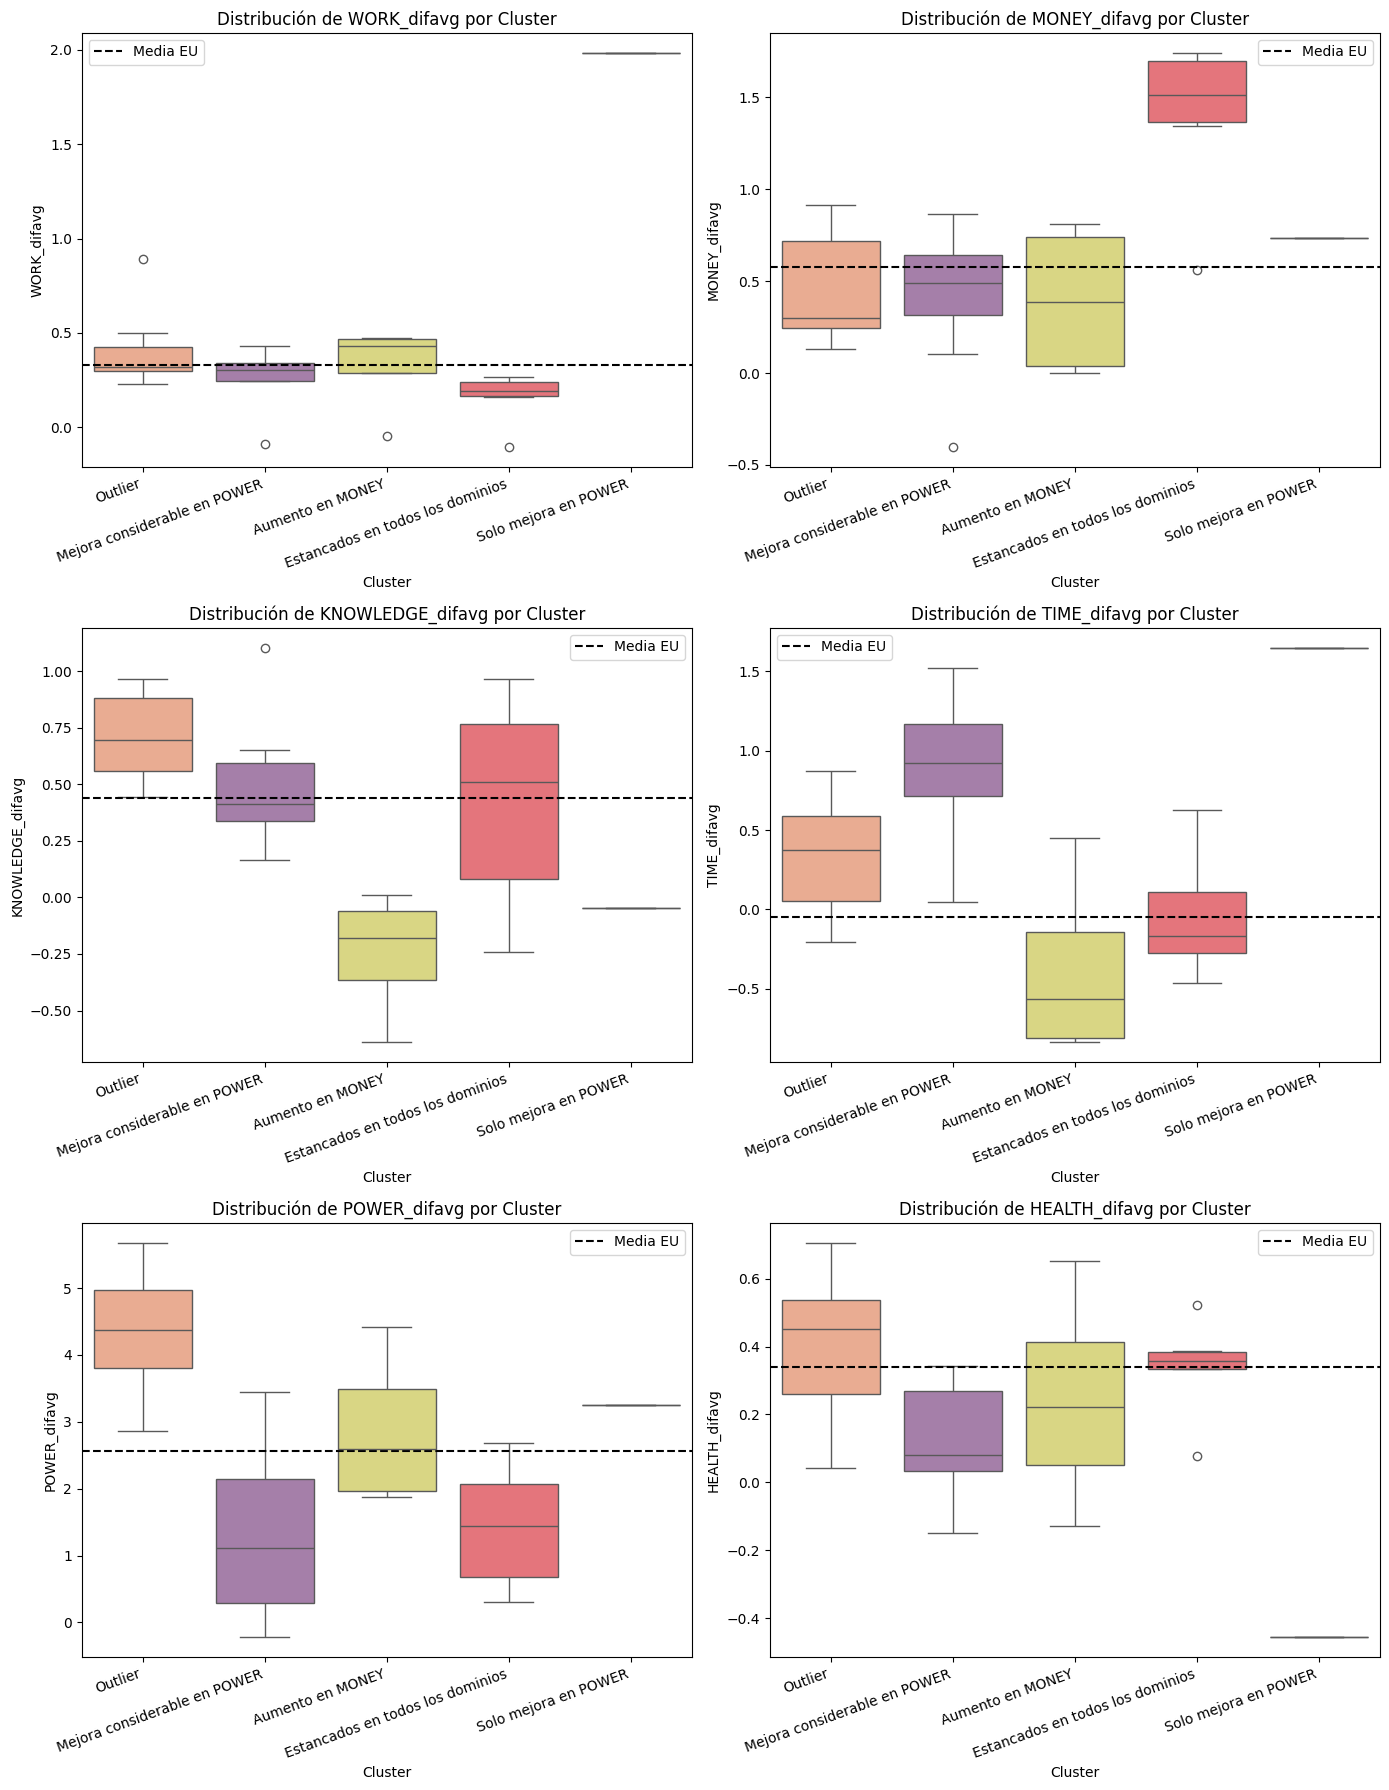

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define eu_means antes de usarlo
eu_means = df_combined.groupby('cluster').mean()

# Lista de todas las variables a graficar
variables = ['WORK_difavg', 'MONEY_difavg', 'KNOWLEDGE_difavg', 'TIME_difavg', 'POWER_difavg', 'HEALTH_difavg']

# Calcular el número de filas necesarias basado en el número de variables (asumiendo 2 columnas)
num_vars = len(variables)
rows = (num_vars // 2) + (num_vars % 2)
fig, ax = plt.subplots(rows, 2, figsize=(14, 6 * rows))  # Ajusta el tamaño según el número de filas

# Filtrar el DataFrame para excluir el cluster 'EU'
df_filtered = df_combined[df_combined['cluster'] != 'EU']

cluster_colors = {
    'Estancados en todos los dominios': "#F7626C",
    'Aumento en MONEY': "#E7E376",
    'Outlier': "#F8A683",
    'Solo mejora en POWER': "#61D76D",
    'Mejora considerable en POWER': "#AB78B0",
}

for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    sns.boxplot(x='cluster', y=var, data=df_filtered, ax=ax[row, col], palette=cluster_colors)
    ax[row, col].set_title(f'Distribución de {var} por Cluster')
    ax[row, col].set_xlabel('Cluster')
    ax[row, col].set_ylabel(var)
    # Añadir una línea horizontal para la media de 'EU' para cada variable
    ax[row, col].axhline(y=eu_means[var]['EU'], color='black', linestyle='--', label='Media EU')
    ax[row, col].legend()  # Muestra la leyenda
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=20, ha="right")  # Ajusta el ángulo según necesites

# Ocultar gráfico vacío si el número de variables es impar
if num_vars % 2 != 0:
    fig.delaxes(ax.flatten()[-1])

plt.tight_layout()
plt.show()


In [103]:
df_combined.reset_index(inplace=True)

In [104]:
df_combined

,ID_Country,WORK_difavg,MONEY_difavg,KNOWLEDGE_difavg,TIME_difavg,POWER_difavg,HEALTH_difavg,cluster,Gender Equality Index,Población,PIB anual,PIB Per Capita,IDH,Deuda total (M.€),Deuda (%PIB),Déficit (%PIB)
0,HR,0.403139,0.916046,0.588682,0.207356,3.558369,0.595591,Outlier,60.689344,3.850894e+06,6.799000e+04,17400.000000,0.858000,4.633400e+04,0.682000,0.001000
1,FR,0.282784,0.198488,0.592871,0.125123,4.871586,0.315301,Outlier,75.140792,6.807070e+07,2.639092e+06,38550.000000,0.903000,2.949331e+06,1.118000,-0.048000
2,ES,0.304585,0.265044,0.796698,0.537505,4.666176,0.517690,Outlier,74.554945,4.832793e+07,1.462070e+06,30320.000000,0.905000,1.502804e+06,1.116000,-0.047300
3,GR,0.321388,-0.404746,0.398751,1.523617,1.083898,0.249583,Mejora considerable en POWER,53.415973,1.039406e+07,2.066200e+05,19550.000000,0.887000,3.565970e+05,1.726000,-0.024000
4,IE,0.497702,0.329716,0.473627,0.551900,4.080354,0.706046,Outlier,74.330251,5.194336e+06,5.062820e+05,98990.000000,0.945000,2.247610e+05,0.444000,0.017000
5,BE,0.466808,0.718566,-0.085167,-0.837967,3.188431,0.333612,Aumento en MONEY,74.196806,1.175400e+07,5.540440e+05,47440.000000,0.937000,5.780630e+05,1.043000,-0.039000
6,DE,0.472065,0.048944,-0.275957,-0.798593,4.412454,0.112221,Aumento en MONEY,68.664431,8.435884e+07,4.121160e+06,48750.000000,0.942000,2.561675e+06,0.661000,-0.025000
7,DK,-0.045491,0.813522,-0.640806,0.451460,1.868553,-0.129309,Aumento en MONEY,77.832795,5.932654e+06,3.746800e+05,62990.000000,0.948000,1.135860e+05,0.298000,0.033000
8,CZ,0.363088,0.866053,0.574857,0.580122,-0.223750,-0.149581,Mejora considerable en POWER,57.239282,1.082753e+07,2.762660e+05,25850.000000,0.889000,1.243000e+05,0.442000,-0.032000
9,BG,0.226187,0.699664,0.966428,-0.207360,2.862672,0.454744,Outlier,60.695323,6.447710e+06,8.580100e+04,13270.000000,0.795000,1.935300e+04,0.226000,-0.029000


In [105]:
#from google.colab import files
#excel_file_2 = 'df_combined.xlsx'
#df_combined.to_excel(excel_file_2, index=False, engine='openpyxl')
#files.download(excel_file_2)